In [1]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

# %tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar

data_dir = "../data"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 224; 
img_width = 224;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)        


Found 11500 files belonging to 10 classes.
Using 9200 files for training.
Found 11500 files belonging to 10 classes.
Using 2300 files for validation.


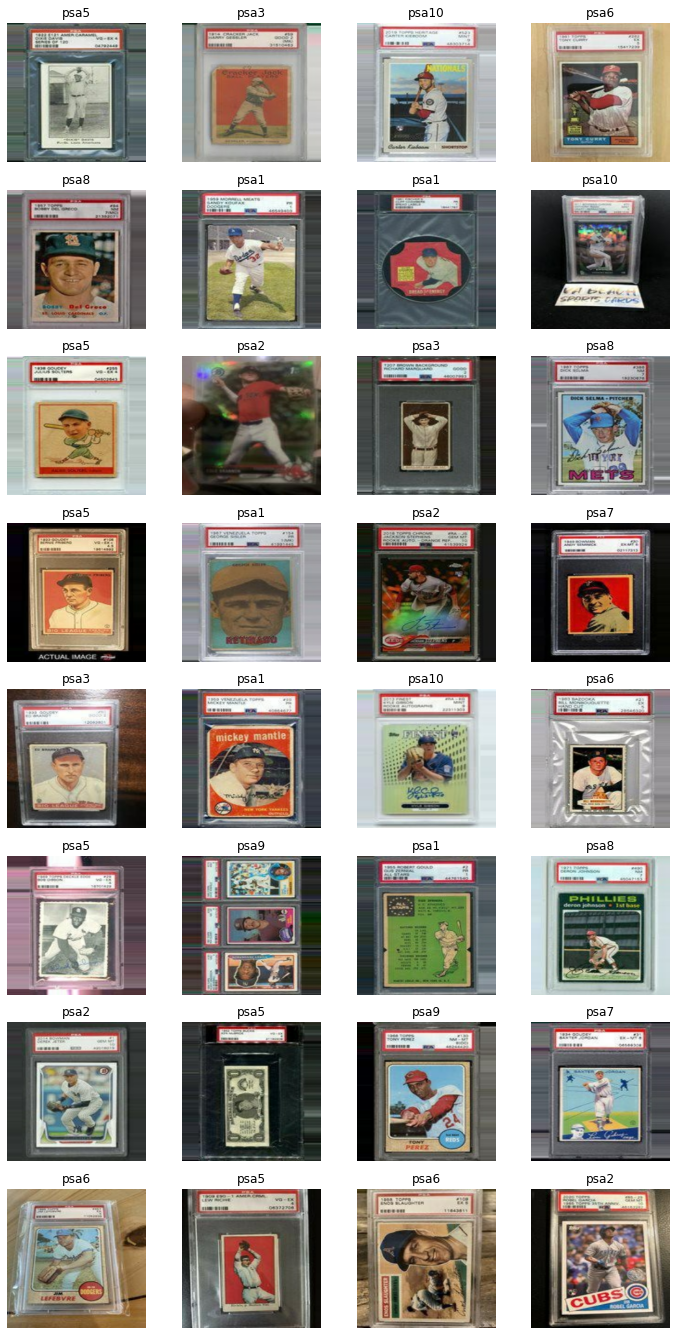

In [4]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['psa' + str(x) for x in range(1,11)]

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


## ResNet50

In [5]:
resNetBase = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet"
)

In [6]:
resNetModel = tf.keras.Sequential([resNetBase,
                                   tf.keras.layers.GlobalAveragePooling2D(),
                                   tf.keras.layers.Dropout(0.5),
                                   tf.keras.layers.Dense(128, activation='relu'),
                                   tf.keras.layers.Dense(10)])

In [7]:
base_learning_rate = 0.001
resNetModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

historyResNet = resNetModel.fit(train_ds, epochs = 100, validation_data=validation_ds)

Epoch 1/100
288/288 [==============================] - 35s 102ms/step - loss: 1.8464 - accuracy: 0.2940 - val_loss: 6.1564 - val_accuracy: 0.1939
Epoch 2/100
288/288 [==============================] - 28s 96ms/step - loss: 1.1054 - accuracy: 0.5703 - val_loss: 4.0889 - val_accuracy: 0.3043
Epoch 3/100
288/288 [==============================] - 28s 96ms/step - loss: 0.7034 - accuracy: 0.7465 - val_loss: 0.9165 - val_accuracy: 0.6848
Epoch 4/100
288/288 [==============================] - 28s 96ms/step - loss: 0.4594 - accuracy: 0.8484 - val_loss: 3.8166 - val_accuracy: 0.2165
Epoch 5/100
288/288 [==============================] - 28s 96ms/step - loss: 0.3621 - accuracy: 0.8810 - val_loss: 1.1422 - val_accuracy: 0.6870
Epoch 6/100
288/288 [==============================] - 28s 96ms/step - loss: 0.3172 - accuracy: 0.8966 - val_loss: 0.4938 - val_accuracy: 0.8361
Epoch 7/100
288/288 [==============================] - 28s 97ms/step - loss: 0.2755 - accuracy: 0.9117 - val_loss: 0.5975 - val_a

288/288 [==============================] - 28s 97ms/step - loss: 0.0499 - accuracy: 0.9871 - val_loss: 0.7393 - val_accuracy: 0.8535
Epoch 58/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0254 - accuracy: 0.9934 - val_loss: 0.4580 - val_accuracy: 0.9148
Epoch 59/100
288/288 [==============================] - 28s 97ms/step - loss: 0.0090 - accuracy: 0.9968 - val_loss: 0.5055 - val_accuracy: 0.9109
Epoch 60/100
288/288 [==============================] - 28s 97ms/step - loss: 0.0160 - accuracy: 0.9958 - val_loss: 0.8467 - val_accuracy: 0.8435
Epoch 61/100
288/288 [==============================] - 28s 97ms/step - loss: 0.0360 - accuracy: 0.9895 - val_loss: 0.7064 - val_accuracy: 0.8635
Epoch 62/100
288/288 [==============================] - 28s 97ms/step - loss: 0.0283 - accuracy: 0.9911 - val_loss: 1.8488 - val_accuracy: 0.6935
Epoch 63/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0351 - accuracy: 0.9905 - val_loss: 0.4045 - val_accuracy

In [8]:
scoreResNet = resNetModel.evaluate(validation_ds)

72/72 [==============================] - 3s 35ms/step - loss: 0.5057 - accuracy: 0.9139


## LeNet
Reference: https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086

In [9]:
leNetModel = tf.keras.Sequential([tf.keras.layers.Conv2D(filters=6, 
                                                         kernel_size=(3, 3),
                                                         activation='relu', 
                                                         input_shape=(224,224,3)),
                                 tf.keras.layers.AveragePooling2D(),
                                 tf.keras.layers.Conv2D(filters=16,
                                                       kernel_size=(3, 3),
                                                       activation='relu'),
                                 tf.keras.layers.AveragePooling2D(),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(units=120, activation='relu'),
                                 tf.keras.layers.Dense(units=84, activation='relu'),
                                 tf.keras.layers.Dense(units=10, activation='softmax')])

In [10]:
base_learning_rate = 0.001
leNetModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

historyLeNet = leNetModel.fit(train_ds, epochs = 100, validation_data=validation_ds)

Epoch 1/100


C:\Users\Max Ryoo\anaconda3\envs\Deeplearning\lib\site-packages\keras\backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


288/288 [==============================] - 7s 21ms/step - loss: 7.9287 - accuracy: 0.1914 - val_loss: 2.1706 - val_accuracy: 0.2348
Epoch 2/100
288/288 [==============================] - 6s 22ms/step - loss: 1.6159 - accuracy: 0.4387 - val_loss: 1.9547 - val_accuracy: 0.3430
Epoch 3/100
288/288 [==============================] - 6s 22ms/step - loss: 1.0292 - accuracy: 0.6526 - val_loss: 2.0420 - val_accuracy: 0.3974
Epoch 4/100
288/288 [==============================] - 7s 22ms/step - loss: 0.5743 - accuracy: 0.8182 - val_loss: 2.2179 - val_accuracy: 0.4252
Epoch 5/100
288/288 [==============================] - 7s 23ms/step - loss: 0.2990 - accuracy: 0.9145 - val_loss: 2.5687 - val_accuracy: 0.4200
Epoch 6/100
288/288 [==============================] - 6s 22ms/step - loss: 0.1452 - accuracy: 0.9657 - val_loss: 2.8843 - val_accuracy: 0.4391
Epoch 7/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0933 - accuracy: 0.9777 - val_loss: 3.3836 - val_accuracy: 0.4143
Epoc

288/288 [==============================] - 7s 22ms/step - loss: 0.0492 - accuracy: 0.9846 - val_loss: 7.6678 - val_accuracy: 0.4478
Epoch 58/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0535 - accuracy: 0.9858 - val_loss: 7.7233 - val_accuracy: 0.4274
Epoch 59/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0185 - accuracy: 0.9955 - val_loss: 7.4027 - val_accuracy: 0.4422
Epoch 60/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0050 - accuracy: 0.9980 - val_loss: 7.3584 - val_accuracy: 0.4530
Epoch 61/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 7.5687 - val_accuracy: 0.4526
Epoch 62/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0019 - accuracy: 0.9991 - val_loss: 7.5612 - val_accuracy: 0.4561
Epoch 63/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0017 - accuracy: 0.9991 - val_loss: 7.5349 - val_accuracy: 0.452

In [11]:
scoreLeNet = leNetModel.evaluate(validation_ds)

72/72 [==============================] - 1s 15ms/step - loss: 7.0508 - accuracy: 0.4561


## AlexNet

Reference: https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

In [12]:
alexNet = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [13]:
alexNet.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
alexNet.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 256)       1024      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 384)      

C:\Users\Max Ryoo\anaconda3\envs\Deeplearning\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
historyAlex = alexNet.fit(train_ds, epochs = 100, validation_data=validation_ds)

Epoch 1/100
288/288 [==============================] - 8s 26ms/step - loss: 3.3155 - accuracy: 0.1349 - val_loss: 2.7047 - val_accuracy: 0.1443
Epoch 2/100
288/288 [==============================] - 7s 26ms/step - loss: 2.5860 - accuracy: 0.1557 - val_loss: 2.1474 - val_accuracy: 0.1913
Epoch 3/100
288/288 [==============================] - 7s 25ms/step - loss: 2.3729 - accuracy: 0.1789 - val_loss: 2.0971 - val_accuracy: 0.2026
Epoch 4/100
288/288 [==============================] - 7s 25ms/step - loss: 2.2360 - accuracy: 0.1940 - val_loss: 2.0702 - val_accuracy: 0.2274
Epoch 5/100
288/288 [==============================] - 7s 25ms/step - loss: 2.1592 - accuracy: 0.2123 - val_loss: 2.0472 - val_accuracy: 0.2183
Epoch 6/100
288/288 [==============================] - 7s 26ms/step - loss: 2.1024 - accuracy: 0.2259 - val_loss: 2.0260 - val_accuracy: 0.2365
Epoch 7/100
288/288 [==============================] - 7s 26ms/step - loss: 2.0658 - accuracy: 0.2377 - val_loss: 2.0326 - val_accuracy:

288/288 [==============================] - 7s 26ms/step - loss: 0.1677 - accuracy: 0.9511 - val_loss: 1.7131 - val_accuracy: 0.5109
Epoch 58/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1640 - accuracy: 0.9538 - val_loss: 1.7290 - val_accuracy: 0.5009
Epoch 59/100
288/288 [==============================] - 7s 26ms/step - loss: 0.1495 - accuracy: 0.9570 - val_loss: 1.8633 - val_accuracy: 0.4852
Epoch 60/100
288/288 [==============================] - 8s 28ms/step - loss: 0.1304 - accuracy: 0.9651 - val_loss: 1.9597 - val_accuracy: 0.4774
Epoch 61/100
288/288 [==============================] - 8s 27ms/step - loss: 0.1314 - accuracy: 0.9648 - val_loss: 2.0413 - val_accuracy: 0.4517
Epoch 62/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1249 - accuracy: 0.9671 - val_loss: 3.1543 - val_accuracy: 0.3270
Epoch 63/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1132 - accuracy: 0.9692 - val_loss: 1.7838 - val_accuracy: 0.511

In [15]:
scoreAlex = alexNet.evaluate(validation_ds)

72/72 [==============================] - 1s 15ms/step - loss: 2.0994 - accuracy: 0.5465


## Learning Rate as the hyperparameter

In [18]:
results = []
for la in [0.001, 0.1, 0.01, 0.0001]:
    resNetBase1 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet"
    )
    resNetModel1 = tf.keras.Sequential([resNetBase1,
                                   tf.keras.layers.GlobalAveragePooling2D(),
                                   tf.keras.layers.Dropout(0.5),
                                   tf.keras.layers.Dense(128, activation='relu'),
                                   tf.keras.layers.Dense(10)])
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=la)
    resNetModel1.compile(optimizer=optimizer1,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    historyResNet1 = resNetModel1.fit(train_ds, epochs = 100, validation_data=validation_ds)
    
    score1 = resNetModel1.evaluate(validation_ds)
    results.append((la, 'Adam', score1))
    
    resNetBase2 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights="imagenet"
    )
    resNetModel2 = tf.keras.Sequential([resNetBase2,
                                   tf.keras.layers.GlobalAveragePooling2D(),
                                   tf.keras.layers.Dropout(0.5),
                                   tf.keras.layers.Dense(128, activation='relu'),
                                   tf.keras.layers.Dense(10)])
    optimizer2 =  tf.optimizers.SGD(lr=la)
    resNetModel2.compile(optimizer=optimizer2,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    historyResNet2 = resNetModel2.fit(train_ds, epochs = 100, validation_data=validation_ds)
    score2 = resNetModel2.evaluate(validation_ds)
    results.append((la, 'SGD', score2))


Epoch 1/100
288/288 [==============================] - 32s 102ms/step - loss: 1.9482 - accuracy: 0.2574 - val_loss: 8.6212 - val_accuracy: 0.1239
Epoch 2/100
288/288 [==============================] - 28s 98ms/step - loss: 1.2345 - accuracy: 0.5299 - val_loss: 3.2654 - val_accuracy: 0.4087
Epoch 3/100
288/288 [==============================] - 28s 99ms/step - loss: 0.7204 - accuracy: 0.7426 - val_loss: 4.3062 - val_accuracy: 0.4030
Epoch 4/100
288/288 [==============================] - 29s 99ms/step - loss: 0.4744 - accuracy: 0.8404 - val_loss: 1.9080 - val_accuracy: 0.4939
Epoch 5/100
288/288 [==============================] - 29s 99ms/step - loss: 0.3894 - accuracy: 0.8721 - val_loss: 2.3884 - val_accuracy: 0.3630
Epoch 6/100
288/288 [==============================] - 29s 99ms/step - loss: 0.3338 - accuracy: 0.8883 - val_loss: 0.7920 - val_accuracy: 0.7843
Epoch 7/100
288/288 [==============================] - 29s 99ms/step - loss: 0.2844 - accuracy: 0.9062 - val_loss: 0.7158 - val_a

288/288 [==============================] - 29s 102ms/step - loss: 0.0147 - accuracy: 0.9951 - val_loss: 0.5176 - val_accuracy: 0.9052
Epoch 58/100
288/288 [==============================] - 32s 110ms/step - loss: 0.0162 - accuracy: 0.9959 - val_loss: 0.5611 - val_accuracy: 0.8978
Epoch 59/100
288/288 [==============================] - 30s 102ms/step - loss: 0.0312 - accuracy: 0.9920 - val_loss: 0.4840 - val_accuracy: 0.9013
Epoch 60/100
288/288 [==============================] - 29s 102ms/step - loss: 0.0549 - accuracy: 0.9842 - val_loss: 0.5632 - val_accuracy: 0.8730
Epoch 61/100
288/288 [==============================] - 29s 102ms/step - loss: 0.0261 - accuracy: 0.9922 - val_loss: 0.4458 - val_accuracy: 0.9109
Epoch 62/100
288/288 [==============================] - 30s 103ms/step - loss: 0.0113 - accuracy: 0.9960 - val_loss: 0.5417 - val_accuracy: 0.9070
Epoch 63/100
288/288 [==============================] - 30s 105ms/step - loss: 0.0312 - accuracy: 0.9920 - val_loss: 0.4138 - val_a

288/288 [==============================] - 27s 94ms/step - loss: 0.7069 - accuracy: 0.7820 - val_loss: 1.5220 - val_accuracy: 0.4687
Epoch 13/100
288/288 [==============================] - 27s 94ms/step - loss: 0.5769 - accuracy: 0.8327 - val_loss: 1.5921 - val_accuracy: 0.4743
Epoch 14/100
288/288 [==============================] - 27s 94ms/step - loss: 0.4574 - accuracy: 0.8727 - val_loss: 1.5310 - val_accuracy: 0.4900
Epoch 15/100
288/288 [==============================] - 27s 94ms/step - loss: 0.3600 - accuracy: 0.9076 - val_loss: 1.5858 - val_accuracy: 0.4957
Epoch 16/100
288/288 [==============================] - 27s 94ms/step - loss: 0.2838 - accuracy: 0.9322 - val_loss: 1.5088 - val_accuracy: 0.5339
Epoch 17/100
288/288 [==============================] - 27s 94ms/step - loss: 0.2229 - accuracy: 0.9512 - val_loss: 1.5361 - val_accuracy: 0.5309
Epoch 18/100
288/288 [==============================] - 27s 94ms/step - loss: 0.1756 - accuracy: 0.9632 - val_loss: 1.3601 - val_accuracy

288/288 [==============================] - 27s 94ms/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 1.5037 - val_accuracy: 0.6539
Epoch 69/100
288/288 [==============================] - 27s 94ms/step - loss: 0.0054 - accuracy: 0.9992 - val_loss: 1.5169 - val_accuracy: 0.6574
Epoch 70/100
288/288 [==============================] - 27s 94ms/step - loss: 0.0056 - accuracy: 0.9988 - val_loss: 1.6397 - val_accuracy: 0.6374
Epoch 71/100
288/288 [==============================] - 27s 94ms/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 1.5339 - val_accuracy: 0.6535
Epoch 72/100
288/288 [==============================] - 27s 94ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 1.5584 - val_accuracy: 0.6522
Epoch 73/100
288/288 [==============================] - 27s 94ms/step - loss: 0.0052 - accuracy: 0.9992 - val_loss: 1.5101 - val_accuracy: 0.6617
Epoch 74/100
288/288 [==============================] - 27s 94ms/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 1.4973 - val_accuracy

288/288 [==============================] - 28s 96ms/step - loss: 2.3149 - accuracy: 0.0995 - val_loss: 2.3117 - val_accuracy: 0.1087
Epoch 24/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3163 - accuracy: 0.1007 - val_loss: 2.3117 - val_accuracy: 0.1013
Epoch 25/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3174 - accuracy: 0.0963 - val_loss: 2.3157 - val_accuracy: 0.0996
Epoch 26/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3171 - accuracy: 0.0973 - val_loss: 2.3138 - val_accuracy: 0.1030
Epoch 27/100
288/288 [==============================] - 28s 97ms/step - loss: 2.3174 - accuracy: 0.0949 - val_loss: 2.3140 - val_accuracy: 0.1030
Epoch 28/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3161 - accuracy: 0.0922 - val_loss: 2.3120 - val_accuracy: 0.1013
Epoch 29/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3156 - accuracy: 0.0967 - val_loss: 2.3092 - val_accuracy

288/288 [==============================] - 28s 96ms/step - loss: 2.3173 - accuracy: 0.0976 - val_loss: 2.3113 - val_accuracy: 0.0996
Epoch 80/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3159 - accuracy: 0.0955 - val_loss: 2.3169 - val_accuracy: 0.0952
Epoch 81/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3173 - accuracy: 0.0970 - val_loss: 2.3135 - val_accuracy: 0.1030
Epoch 82/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3158 - accuracy: 0.1020 - val_loss: 2.3116 - val_accuracy: 0.1030
Epoch 83/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3169 - accuracy: 0.1004 - val_loss: 2.3156 - val_accuracy: 0.1030
Epoch 84/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3175 - accuracy: 0.1000 - val_loss: 2.3072 - val_accuracy: 0.0952
Epoch 85/100
288/288 [==============================] - 28s 96ms/step - loss: 2.3149 - accuracy: 0.0991 - val_loss: 2.3149 - val_accuracy

288/288 [==============================] - 28s 96ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.5128 - val_accuracy: 0.9030
Epoch 35/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.5049 - val_accuracy: 0.9170
Epoch 36/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0091 - accuracy: 0.9978 - val_loss: 0.5304 - val_accuracy: 0.9096
Epoch 37/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.4949 - val_accuracy: 0.9191
Epoch 38/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.4895 - val_accuracy: 0.9243
Epoch 39/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.5014 - val_accuracy: 0.9213
Epoch 40/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.5120 - val_accuracy

288/288 [==============================] - 28s 95ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.4815 - val_accuracy: 0.9235
Epoch 91/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.5166 - val_accuracy: 0.9174
Epoch 92/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.5127 - val_accuracy: 0.9209
Epoch 93/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.5200 - val_accuracy: 0.9217
Epoch 94/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.5155 - val_accuracy: 0.9261
Epoch 95/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0021 - accuracy: 0.9990 - val_loss: 0.5165 - val_accuracy: 0.9248
Epoch 96/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.5177 - val_accuracy

288/288 [==============================] - 28s 96ms/step - loss: 1.9341 - accuracy: 0.2353 - val_loss: 1.9597 - val_accuracy: 0.2278
Epoch 46/100
288/288 [==============================] - 28s 96ms/step - loss: 1.8480 - accuracy: 0.2641 - val_loss: 2.0378 - val_accuracy: 0.2117
Epoch 47/100
288/288 [==============================] - 28s 97ms/step - loss: 1.7714 - accuracy: 0.2920 - val_loss: 1.8507 - val_accuracy: 0.2687
Epoch 48/100
288/288 [==============================] - 28s 97ms/step - loss: 1.7000 - accuracy: 0.3017 - val_loss: 2.3030 - val_accuracy: 0.2426
Epoch 49/100
288/288 [==============================] - 28s 96ms/step - loss: 1.6415 - accuracy: 0.3262 - val_loss: 1.5971 - val_accuracy: 0.3578
Epoch 50/100
288/288 [==============================] - 28s 96ms/step - loss: 1.5154 - accuracy: 0.3949 - val_loss: 1.7148 - val_accuracy: 0.3743
Epoch 51/100
288/288 [==============================] - 28s 96ms/step - loss: 1.2894 - accuracy: 0.4835 - val_loss: 1.5334 - val_accuracy

72/72 [==============================] - 3s 35ms/step - loss: 1.2156 - accuracy: 0.6383
Epoch 1/100
288/288 [==============================] - 30s 98ms/step - loss: 1.9679 - accuracy: 0.2655 - val_loss: 1.6782 - val_accuracy: 0.3787
Epoch 2/100
288/288 [==============================] - 28s 97ms/step - loss: 0.9112 - accuracy: 0.6676 - val_loss: 1.1599 - val_accuracy: 0.6209
Epoch 3/100
288/288 [==============================] - 28s 97ms/step - loss: 0.3848 - accuracy: 0.8711 - val_loss: 0.5875 - val_accuracy: 0.8087
Epoch 4/100
288/288 [==============================] - 28s 97ms/step - loss: 0.2245 - accuracy: 0.9273 - val_loss: 0.3936 - val_accuracy: 0.8804
Epoch 5/100
288/288 [==============================] - 28s 97ms/step - loss: 0.1473 - accuracy: 0.9518 - val_loss: 0.4340 - val_accuracy: 0.8770
Epoch 6/100
288/288 [==============================] - 28s 97ms/step - loss: 0.0970 - accuracy: 0.9708 - val_loss: 0.4789 - val_accuracy: 0.8709
Epoch 7/100
288/288 [=====================

288/288 [==============================] - 27s 95ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.5719 - val_accuracy: 0.9157
Epoch 57/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.5752 - val_accuracy: 0.9157
Epoch 58/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.5673 - val_accuracy: 0.9148
Epoch 59/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0015 - accuracy: 0.9995 - val_loss: 0.5738 - val_accuracy: 0.9143
Epoch 60/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.5721 - val_accuracy: 0.9143
Epoch 61/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.5704 - val_accuracy: 0.9161
Epoch 62/100
288/288 [==============================] - 27s 95ms/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.5722 - val_accuracy

288/288 [==============================] - 28s 96ms/step - loss: 0.0413 - accuracy: 0.9877 - val_loss: 0.4919 - val_accuracy: 0.8961
Epoch 12/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0405 - accuracy: 0.9877 - val_loss: 0.4215 - val_accuracy: 0.9030
Epoch 13/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0252 - accuracy: 0.9929 - val_loss: 0.4992 - val_accuracy: 0.8970
Epoch 14/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0375 - accuracy: 0.9893 - val_loss: 0.6121 - val_accuracy: 0.8791
Epoch 15/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0469 - accuracy: 0.9884 - val_loss: 0.4828 - val_accuracy: 0.9083
Epoch 16/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0332 - accuracy: 0.9902 - val_loss: 0.4998 - val_accuracy: 0.8917
Epoch 17/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0356 - accuracy: 0.9902 - val_loss: 0.6440 - val_accuracy

288/288 [==============================] - 28s 95ms/step - loss: 0.0340 - accuracy: 0.9905 - val_loss: 0.4465 - val_accuracy: 0.9057
Epoch 68/100
288/288 [==============================] - 28s 95ms/step - loss: 0.0111 - accuracy: 0.9968 - val_loss: 0.4678 - val_accuracy: 0.9091
Epoch 69/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0111 - accuracy: 0.9971 - val_loss: 0.3919 - val_accuracy: 0.9152
Epoch 70/100
288/288 [==============================] - 28s 95ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.4459 - val_accuracy: 0.9143
Epoch 71/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.4051 - val_accuracy: 0.9178
Epoch 72/100
288/288 [==============================] - 28s 95ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.4617 - val_accuracy: 0.9139
Epoch 73/100
288/288 [==============================] - 28s 96ms/step - loss: 0.0166 - accuracy: 0.9965 - val_loss: 0.4743 - val_accuracy

288/288 [==============================] - 27s 94ms/step - loss: 2.0564 - accuracy: 0.2515 - val_loss: 2.1735 - val_accuracy: 0.1891
Epoch 23/100
288/288 [==============================] - 27s 94ms/step - loss: 2.0470 - accuracy: 0.2517 - val_loss: 2.1677 - val_accuracy: 0.1917
Epoch 24/100
288/288 [==============================] - 27s 94ms/step - loss: 2.0266 - accuracy: 0.2625 - val_loss: 2.1603 - val_accuracy: 0.2000
Epoch 25/100
288/288 [==============================] - 27s 94ms/step - loss: 2.0120 - accuracy: 0.2733 - val_loss: 2.1544 - val_accuracy: 0.2009
Epoch 26/100
288/288 [==============================] - 27s 94ms/step - loss: 1.9952 - accuracy: 0.2787 - val_loss: 2.1487 - val_accuracy: 0.2065
Epoch 27/100
288/288 [==============================] - 27s 94ms/step - loss: 1.9858 - accuracy: 0.2818 - val_loss: 2.1456 - val_accuracy: 0.2035
Epoch 28/100
288/288 [==============================] - 27s 94ms/step - loss: 1.9781 - accuracy: 0.2843 - val_loss: 2.1373 - val_accuracy

288/288 [==============================] - 28s 95ms/step - loss: 1.1632 - accuracy: 0.6329 - val_loss: 1.8806 - val_accuracy: 0.3383
Epoch 79/100
288/288 [==============================] - 28s 95ms/step - loss: 1.1595 - accuracy: 0.6330 - val_loss: 1.8723 - val_accuracy: 0.3417
Epoch 80/100
288/288 [==============================] - 27s 95ms/step - loss: 1.1486 - accuracy: 0.6329 - val_loss: 1.8604 - val_accuracy: 0.3474
Epoch 81/100
288/288 [==============================] - 28s 95ms/step - loss: 1.1163 - accuracy: 0.6499 - val_loss: 1.8516 - val_accuracy: 0.3552
Epoch 82/100
288/288 [==============================] - 28s 95ms/step - loss: 1.0991 - accuracy: 0.6545 - val_loss: 1.8362 - val_accuracy: 0.3604
Epoch 83/100
288/288 [==============================] - 28s 95ms/step - loss: 1.0785 - accuracy: 0.6585 - val_loss: 1.8351 - val_accuracy: 0.3570
Epoch 84/100
288/288 [==============================] - 28s 95ms/step - loss: 1.0613 - accuracy: 0.6685 - val_loss: 1.8289 - val_accuracy

In [19]:
results

[(0.001, 'Adam', [0.520152747631073, 0.8899999856948853]),
 (0.001, 'SGD', [1.51031494140625, 0.6695652008056641]),
 (0.1, 'Adam', [2.320620536804199, 0.09521739184856415]),
 (0.1, 'SGD', [0.5373412370681763, 0.926086962223053]),
 (0.01, 'Adam', [1.2156214714050293, 0.6382608413696289]),
 (0.01, 'SGD', [0.5610789656639099, 0.9108695387840271]),
 (0.0001, 'Adam', [0.6319554448127747, 0.8860869407653809]),
 (0.0001, 'SGD', [1.6924606561660767, 0.4247826039791107])]

In [27]:
import pandas as pd
import numpy as np

In [43]:
resnetdf = pd.DataFrame([[x[0], x[1], x[2][1]] for x in results], 
                        columns=['LearningRate', 'Optimizer', 'Accuracy'])

In [44]:
resnetdf.sort_values(by='Accuracy', ascending=False)

,LearningRate,Optimizer,Accuracy
3,0.1000,SGD,0.926087
5,0.0100,SGD,0.910870
0,0.0010,Adam,0.890000
6,0.0001,Adam,0.886087
1,0.0010,SGD,0.669565
4,0.0100,Adam,0.638261
7,0.0001,SGD,0.424783
2,0.1000,Adam,0.095217


In [37]:
resultsLeNet = []
for la in [0.001, 0.1, 0.01, 0.0001]:
    leNetModel = tf.keras.Sequential([tf.keras.layers.Conv2D(filters=6, 
                                                         kernel_size=(3, 3),
                                                         activation='relu', 
                                                         input_shape=(224,224,3)),
                                 tf.keras.layers.AveragePooling2D(),
                                 tf.keras.layers.Conv2D(filters=16,
                                                       kernel_size=(3, 3),
                                                       activation='relu'),
                                 tf.keras.layers.AveragePooling2D(),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(units=120, activation='relu'),
                                 tf.keras.layers.Dense(units=84, activation='relu'),
                                 tf.keras.layers.Dense(units=10, activation='softmax')])
    base_learning_rate = la
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
    leNetModel.compile(optimizer=optimizer1,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    historyLeNet1 = leNetModel.fit(train_ds, epochs = 100, validation_data=validation_ds)
    scoreLeNet1 = leNetModel.evaluate(validation_ds)
    resultsLeNet.append((la, 'Adam', scoreLeNet1))

    leNetModel2 = tf.keras.Sequential([tf.keras.layers.Conv2D(filters=6, 
                                                         kernel_size=(3, 3),
                                                         activation='relu', 
                                                         input_shape=(224,224,3)),
                                 tf.keras.layers.AveragePooling2D(),
                                 tf.keras.layers.Conv2D(filters=16,
                                                       kernel_size=(3, 3),
                                                       activation='relu'),
                                 tf.keras.layers.AveragePooling2D(),
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(units=120, activation='relu'),
                                 tf.keras.layers.Dense(units=84, activation='relu'),
                                 tf.keras.layers.Dense(units=10, activation='softmax')])    
    optimizer2 =  tf.optimizers.SGD(lr=la)
    leNetModel2.compile(optimizer=optimizer2,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    historyLeNet2 = leNetModel2.fit(train_ds, epochs = 100, validation_data=validation_ds)
    scoreLeNet2 = leNetModel2.evaluate(validation_ds)
    resultsLeNet.append((la, 'SGD', scoreLeNet2))


Epoch 1/100
288/288 [==============================] - 6s 20ms/step - loss: 22.9879 - accuracy: 0.1459 - val_loss: 2.2061 - val_accuracy: 0.1813
Epoch 2/100
288/288 [==============================] - 7s 23ms/step - loss: 2.0071 - accuracy: 0.2763 - val_loss: 2.1683 - val_accuracy: 0.2313
Epoch 3/100
288/288 [==============================] - 7s 23ms/step - loss: 1.4893 - accuracy: 0.4927 - val_loss: 2.3406 - val_accuracy: 0.2461
Epoch 4/100
288/288 [==============================] - 7s 23ms/step - loss: 0.8726 - accuracy: 0.7164 - val_loss: 3.2363 - val_accuracy: 0.2609
Epoch 5/100
288/288 [==============================] - 7s 23ms/step - loss: 0.4388 - accuracy: 0.8640 - val_loss: 3.7711 - val_accuracy: 0.2791
Epoch 6/100
288/288 [==============================] - 6s 21ms/step - loss: 0.2343 - accuracy: 0.9362 - val_loss: 4.5796 - val_accuracy: 0.2752
Epoch 7/100
288/288 [==============================] - 7s 23ms/step - loss: 0.1503 - accuracy: 0.9601 - val_loss: 4.7686 - val_accuracy

288/288 [==============================] - 7s 23ms/step - loss: 0.0253 - accuracy: 0.9933 - val_loss: 9.7565 - val_accuracy: 0.2791
Epoch 58/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0218 - accuracy: 0.9945 - val_loss: 10.2206 - val_accuracy: 0.2800
Epoch 59/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0076 - accuracy: 0.9982 - val_loss: 9.9743 - val_accuracy: 0.2822
Epoch 60/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0058 - accuracy: 0.9978 - val_loss: 10.5992 - val_accuracy: 0.2783
Epoch 61/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 10.2795 - val_accuracy: 0.2770
Epoch 62/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0440 - accuracy: 0.9889 - val_loss: 10.3637 - val_accuracy: 0.2704
Epoch 63/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0415 - accuracy: 0.9933 - val_loss: 10.9558 - val_accuracy: 

C:\Users\Max Ryoo\anaconda3\envs\Deeplearning\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


288/288 [==============================] - 7s 24ms/step - loss: 3.3497 - accuracy: 0.1047 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 2/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3025 - accuracy: 0.1035 - val_loss: 2.3030 - val_accuracy: 0.0987
Epoch 3/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3025 - accuracy: 0.1035 - val_loss: 2.3030 - val_accuracy: 0.0974
Epoch 4/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3024 - accuracy: 0.1042 - val_loss: 2.3029 - val_accuracy: 0.0978
Epoch 5/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3024 - accuracy: 0.1036 - val_loss: 2.3029 - val_accuracy: 0.0974
Epoch 6/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3024 - accuracy: 0.1047 - val_loss: 2.3029 - val_accuracy: 0.0983
Epoch 7/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3023 - accuracy: 0.1050 - val_loss: 2.3029 - val_accuracy: 0.0978
Epoc

288/288 [==============================] - 7s 23ms/step - loss: 2.2991 - accuracy: 0.1152 - val_loss: 2.3025 - val_accuracy: 0.1030
Epoch 58/100
288/288 [==============================] - 7s 23ms/step - loss: 2.2989 - accuracy: 0.1172 - val_loss: 2.3023 - val_accuracy: 0.1039
Epoch 59/100
288/288 [==============================] - 7s 23ms/step - loss: 2.2983 - accuracy: 0.1188 - val_loss: 2.3019 - val_accuracy: 0.1052
Epoch 60/100
288/288 [==============================] - 7s 23ms/step - loss: 2.2983 - accuracy: 0.1187 - val_loss: 2.3022 - val_accuracy: 0.1048
Epoch 61/100
288/288 [==============================] - 7s 23ms/step - loss: 2.2981 - accuracy: 0.1190 - val_loss: 2.3015 - val_accuracy: 0.1057
Epoch 62/100
288/288 [==============================] - 7s 23ms/step - loss: 2.2972 - accuracy: 0.1209 - val_loss: 2.3020 - val_accuracy: 0.1061
Epoch 63/100
288/288 [==============================] - 7s 23ms/step - loss: 2.2966 - accuracy: 0.1202 - val_loss: 2.3009 - val_accuracy: 0.106

288/288 [==============================] - 7s 23ms/step - loss: 2.3164 - accuracy: 0.0993 - val_loss: 2.3090 - val_accuracy: 0.0952
Epoch 14/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3157 - accuracy: 0.1022 - val_loss: 2.3144 - val_accuracy: 0.0952
Epoch 15/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3158 - accuracy: 0.0973 - val_loss: 2.3139 - val_accuracy: 0.0996
Epoch 16/100
288/288 [==============================] - 6s 22ms/step - loss: 2.3165 - accuracy: 0.0972 - val_loss: 2.3145 - val_accuracy: 0.1013
Epoch 17/100
288/288 [==============================] - 7s 22ms/step - loss: 2.3160 - accuracy: 0.0971 - val_loss: 2.3166 - val_accuracy: 0.1030
Epoch 18/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3169 - accuracy: 0.0970 - val_loss: 2.3085 - val_accuracy: 0.1087
Epoch 19/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3173 - accuracy: 0.0966 - val_loss: 2.3172 - val_accuracy: 0.103

288/288 [==============================] - 6s 22ms/step - loss: 2.3166 - accuracy: 0.0975 - val_loss: 2.3095 - val_accuracy: 0.0991
Epoch 70/100
288/288 [==============================] - 6s 22ms/step - loss: 2.3163 - accuracy: 0.0991 - val_loss: 2.3120 - val_accuracy: 0.0952
Epoch 71/100
288/288 [==============================] - 6s 22ms/step - loss: 2.3164 - accuracy: 0.1008 - val_loss: 2.3202 - val_accuracy: 0.1013
Epoch 72/100
288/288 [==============================] - 6s 22ms/step - loss: 2.3150 - accuracy: 0.0997 - val_loss: 2.3135 - val_accuracy: 0.1030
Epoch 73/100
288/288 [==============================] - 6s 22ms/step - loss: 2.3156 - accuracy: 0.1009 - val_loss: 2.3162 - val_accuracy: 0.1030
Epoch 74/100
288/288 [==============================] - 6s 22ms/step - loss: 2.3156 - accuracy: 0.0949 - val_loss: 2.3100 - val_accuracy: 0.1030
Epoch 75/100
288/288 [==============================] - 6s 22ms/step - loss: 2.3164 - accuracy: 0.1005 - val_loss: 2.3098 - val_accuracy: 0.101

Epoch 25/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0915 - val_loss: 2.3027 - val_accuracy: 0.1013
Epoch 26/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3038 - accuracy: 0.0933 - val_loss: 2.3028 - val_accuracy: 0.1013
Epoch 27/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0948 - val_loss: 2.3027 - val_accuracy: 0.1013
Epoch 28/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0952 - val_loss: 2.3027 - val_accuracy: 0.1013
Epoch 29/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0951 - val_loss: 2.3026 - val_accuracy: 0.1013
Epoch 30/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0933 - val_loss: 2.3027 - val_accuracy: 0.1013
Epoch 31/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0935 - val_loss: 2.3026 - val_ac

288/288 [==============================] - 7s 23ms/step - loss: 2.3038 - accuracy: 0.0964 - val_loss: 2.3027 - val_accuracy: 0.1013
Epoch 82/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0972 - val_loss: 2.3028 - val_accuracy: 0.1013
Epoch 83/100
288/288 [==============================] - 6s 22ms/step - loss: 2.3037 - accuracy: 0.0952 - val_loss: 2.3027 - val_accuracy: 0.1013
Epoch 84/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0913 - val_loss: 2.3026 - val_accuracy: 0.1013
Epoch 85/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0932 - val_loss: 2.3027 - val_accuracy: 0.1013
Epoch 86/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3037 - accuracy: 0.0980 - val_loss: 2.3028 - val_accuracy: 0.1013
Epoch 87/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3038 - accuracy: 0.0938 - val_loss: 2.3027 - val_accuracy: 0.101

288/288 [==============================] - 7s 22ms/step - loss: 1.2793 - accuracy: 0.5314 - val_loss: 6.6102 - val_accuracy: 0.1639
Epoch 38/100
288/288 [==============================] - 6s 22ms/step - loss: 1.2281 - accuracy: 0.5420 - val_loss: 7.5170 - val_accuracy: 0.1743
Epoch 39/100
288/288 [==============================] - 6s 22ms/step - loss: 1.2628 - accuracy: 0.5367 - val_loss: 5.0613 - val_accuracy: 0.1570
Epoch 40/100
288/288 [==============================] - 7s 23ms/step - loss: 1.3786 - accuracy: 0.5102 - val_loss: 9.2875 - val_accuracy: 0.1674
Epoch 41/100
288/288 [==============================] - 7s 22ms/step - loss: 1.3516 - accuracy: 0.5255 - val_loss: 8.9578 - val_accuracy: 0.1739
Epoch 42/100
288/288 [==============================] - 7s 22ms/step - loss: 1.2800 - accuracy: 0.5370 - val_loss: 10.9802 - val_accuracy: 0.1848
Epoch 43/100
288/288 [==============================] - 7s 22ms/step - loss: 1.3211 - accuracy: 0.5236 - val_loss: 6.6179 - val_accuracy: 0.18

288/288 [==============================] - 7s 23ms/step - loss: 1.0873 - accuracy: 0.6007 - val_loss: 13.0827 - val_accuracy: 0.1852
Epoch 94/100
288/288 [==============================] - 7s 23ms/step - loss: 1.1149 - accuracy: 0.5904 - val_loss: 9.1140 - val_accuracy: 0.1670
Epoch 95/100
288/288 [==============================] - 6s 22ms/step - loss: 1.2001 - accuracy: 0.5748 - val_loss: 11.4162 - val_accuracy: 0.1765
Epoch 96/100
288/288 [==============================] - 7s 22ms/step - loss: 1.3202 - accuracy: 0.5568 - val_loss: 8.1915 - val_accuracy: 0.1743
Epoch 97/100
288/288 [==============================] - 7s 23ms/step - loss: 1.2061 - accuracy: 0.5786 - val_loss: 7.7414 - val_accuracy: 0.1626
Epoch 98/100
288/288 [==============================] - 7s 22ms/step - loss: 1.1247 - accuracy: 0.5950 - val_loss: 10.9151 - val_accuracy: 0.1757
Epoch 99/100
288/288 [==============================] - 6s 22ms/step - loss: 1.1975 - accuracy: 0.5733 - val_loss: 10.8970 - val_accuracy: 0

288/288 [==============================] - 7s 23ms/step - loss: 2.3026 - accuracy: 0.1000 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 50/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3026 - accuracy: 0.1001 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 51/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3026 - accuracy: 0.0995 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 52/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3026 - accuracy: 0.0997 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 53/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3026 - accuracy: 0.0989 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 54/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3026 - accuracy: 0.0998 - val_loss: 2.3027 - val_accuracy: 0.0952
Epoch 55/100
288/288 [==============================] - 7s 23ms/step - loss: 2.3026 - accuracy: 0.1008 - val_loss: 2.3027 - val_accuracy: 0.095

Epoch 5/100
288/288 [==============================] - 7s 22ms/step - loss: 2.2905 - accuracy: 0.3739 - val_loss: 3.1641 - val_accuracy: 0.2396
Epoch 6/100
288/288 [==============================] - 6s 22ms/step - loss: 1.7646 - accuracy: 0.4495 - val_loss: 2.8576 - val_accuracy: 0.2657
Epoch 7/100
288/288 [==============================] - 7s 23ms/step - loss: 1.4458 - accuracy: 0.5207 - val_loss: 3.1426 - val_accuracy: 0.2570
Epoch 8/100
288/288 [==============================] - 7s 23ms/step - loss: 1.2045 - accuracy: 0.5891 - val_loss: 2.8751 - val_accuracy: 0.2861
Epoch 9/100
288/288 [==============================] - 7s 23ms/step - loss: 1.0372 - accuracy: 0.6488 - val_loss: 2.7727 - val_accuracy: 0.2952
Epoch 10/100
288/288 [==============================] - 6s 22ms/step - loss: 0.8998 - accuracy: 0.6953 - val_loss: 2.8883 - val_accuracy: 0.3022
Epoch 11/100
288/288 [==============================] - 6s 22ms/step - loss: 0.7524 - accuracy: 0.7550 - val_loss: 2.8450 - val_accurac

288/288 [==============================] - 7s 23ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 6.1603 - val_accuracy: 0.4109
Epoch 62/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 6.1741 - val_accuracy: 0.4070
Epoch 63/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 6.1992 - val_accuracy: 0.4078
Epoch 64/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 6.1612 - val_accuracy: 0.4117
Epoch 65/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 6.2073 - val_accuracy: 0.4091
Epoch 66/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 6.2204 - val_accuracy: 0.4048
Epoch 67/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 6.1170 - val_accuracy: 0.407

288/288 [==============================] - 7s 23ms/step - loss: 1.7288 - accuracy: 0.3915 - val_loss: 2.1030 - val_accuracy: 0.2387
Epoch 18/100
288/288 [==============================] - 7s 23ms/step - loss: 1.6914 - accuracy: 0.4097 - val_loss: 2.0968 - val_accuracy: 0.2396
Epoch 19/100
288/288 [==============================] - 7s 23ms/step - loss: 1.6534 - accuracy: 0.4270 - val_loss: 2.1034 - val_accuracy: 0.2474
Epoch 20/100
288/288 [==============================] - 6s 22ms/step - loss: 1.6127 - accuracy: 0.4430 - val_loss: 2.0962 - val_accuracy: 0.2552
Epoch 21/100
288/288 [==============================] - 7s 23ms/step - loss: 1.5724 - accuracy: 0.4608 - val_loss: 2.1041 - val_accuracy: 0.2548
Epoch 22/100
288/288 [==============================] - 7s 23ms/step - loss: 1.5294 - accuracy: 0.4774 - val_loss: 2.0994 - val_accuracy: 0.2557
Epoch 23/100
288/288 [==============================] - 7s 23ms/step - loss: 1.4843 - accuracy: 0.5009 - val_loss: 2.1085 - val_accuracy: 0.260

288/288 [==============================] - 7s 23ms/step - loss: 0.0463 - accuracy: 0.9987 - val_loss: 3.5736 - val_accuracy: 0.3630
Epoch 74/100
288/288 [==============================] - 6s 22ms/step - loss: 0.0424 - accuracy: 0.9991 - val_loss: 3.6392 - val_accuracy: 0.3565
Epoch 75/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0407 - accuracy: 0.9991 - val_loss: 3.6584 - val_accuracy: 0.3557
Epoch 76/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0385 - accuracy: 0.9991 - val_loss: 3.6636 - val_accuracy: 0.3639
Epoch 77/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0370 - accuracy: 0.9993 - val_loss: 3.6629 - val_accuracy: 0.3630
Epoch 78/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0350 - accuracy: 0.9990 - val_loss: 3.7136 - val_accuracy: 0.3639
Epoch 79/100
288/288 [==============================] - 7s 23ms/step - loss: 0.0338 - accuracy: 0.9990 - val_loss: 3.7026 - val_accuracy: 0.363

In [45]:
lenetdf = pd.DataFrame([[x[0], x[1], x[2][1]] for x in resultsLeNet], 
                        columns=['LearningRate', 'Optimizer', 'Accuracy'])

In [46]:
lenetdf.sort_values(by='Accuracy', ascending=False)

,LearningRate,Optimizer,Accuracy
6,0.0001,Adam,0.413913
7,0.0001,SGD,0.365652
1,0.0010,SGD,0.281304
0,0.0010,Adam,0.279565
4,0.0100,Adam,0.186087
3,0.1000,SGD,0.101304
2,0.1000,Adam,0.095217
5,0.0100,SGD,0.095217


In [40]:
resultsAlexNet = []
for la in [0.001, 0.1, 0.01, 0.0001]:
    alexNet = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    base_learning_rate = la
    optimizer1 = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
    alexNet.compile(optimizer=optimizer1,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    historyAlexNet1 = alexNet.fit(train_ds, epochs = 100, validation_data=validation_ds)
    scoreAlexNet1 = alexNet.evaluate(validation_ds)
    resultsAlexNet.append((la, 'Adam', scoreAlexNet1))

    alexNet2 = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
    optimizer2 =  tf.optimizers.SGD(lr=la)
    alexNet2.compile(optimizer=optimizer2,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    historyAlexNet2 = alexNet2.fit(train_ds, epochs = 100, validation_data=validation_ds)
    scoreAlexNet2 = alexNet2.evaluate(validation_ds)
    resultsAlexNet.append((la, 'SGD', scoreAlexNet2))


Epoch 1/100


C:\Users\Max Ryoo\anaconda3\envs\Deeplearning\lib\site-packages\keras\backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


288/288 [==============================] - 8s 27ms/step - loss: 5.0056 - accuracy: 0.1325 - val_loss: 2.2453 - val_accuracy: 0.1570
Epoch 2/100
288/288 [==============================] - 8s 26ms/step - loss: 2.2863 - accuracy: 0.1355 - val_loss: 2.2362 - val_accuracy: 0.1457
Epoch 3/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3060 - accuracy: 0.1362 - val_loss: 2.2040 - val_accuracy: 0.1539
Epoch 4/100
288/288 [==============================] - 8s 26ms/step - loss: 2.2749 - accuracy: 0.1392 - val_loss: 2.1800 - val_accuracy: 0.1700
Epoch 5/100
288/288 [==============================] - 8s 26ms/step - loss: 2.2502 - accuracy: 0.1478 - val_loss: 2.2007 - val_accuracy: 0.1448
Epoch 6/100
288/288 [==============================] - 8s 26ms/step - loss: 2.2191 - accuracy: 0.1508 - val_loss: 2.1647 - val_accuracy: 0.1722
Epoch 7/100
288/288 [==============================] - 8s 26ms/step - loss: 2.2094 - accuracy: 0.1542 - val_loss: 2.1961 - val_accuracy: 0.1548
Epoc

288/288 [==============================] - 8s 26ms/step - loss: 0.2969 - accuracy: 0.8998 - val_loss: 1.5474 - val_accuracy: 0.6178
Epoch 58/100
288/288 [==============================] - 8s 26ms/step - loss: 0.3030 - accuracy: 0.8983 - val_loss: 5.5858 - val_accuracy: 0.5791
Epoch 59/100
288/288 [==============================] - 8s 26ms/step - loss: 0.3031 - accuracy: 0.9024 - val_loss: 2.1410 - val_accuracy: 0.6639
Epoch 60/100
288/288 [==============================] - 8s 26ms/step - loss: 0.2515 - accuracy: 0.9162 - val_loss: 1.1420 - val_accuracy: 0.6574
Epoch 61/100
288/288 [==============================] - 8s 26ms/step - loss: 0.2559 - accuracy: 0.9177 - val_loss: 1.5052 - val_accuracy: 0.5596
Epoch 62/100
288/288 [==============================] - 8s 26ms/step - loss: 0.2174 - accuracy: 0.9288 - val_loss: 1.8797 - val_accuracy: 0.6757
Epoch 63/100
288/288 [==============================] - 8s 26ms/step - loss: 0.2451 - accuracy: 0.9182 - val_loss: 1.9030 - val_accuracy: 0.633

C:\Users\Max Ryoo\anaconda3\envs\Deeplearning\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


288/288 [==============================] - 8s 26ms/step - loss: 3.2458 - accuracy: 0.1326 - val_loss: 2.2739 - val_accuracy: 0.1665
Epoch 2/100
288/288 [==============================] - 7s 25ms/step - loss: 2.5646 - accuracy: 0.1607 - val_loss: 2.4475 - val_accuracy: 0.1730
Epoch 3/100
288/288 [==============================] - 7s 25ms/step - loss: 2.3460 - accuracy: 0.1845 - val_loss: 2.1283 - val_accuracy: 0.2026
Epoch 4/100
288/288 [==============================] - 7s 25ms/step - loss: 2.2455 - accuracy: 0.1920 - val_loss: 2.0763 - val_accuracy: 0.1970
Epoch 5/100
288/288 [==============================] - 7s 25ms/step - loss: 2.1640 - accuracy: 0.2035 - val_loss: 2.0646 - val_accuracy: 0.2052
Epoch 6/100
288/288 [==============================] - 7s 25ms/step - loss: 2.1022 - accuracy: 0.2270 - val_loss: 2.0385 - val_accuracy: 0.2217
Epoch 7/100
288/288 [==============================] - 7s 25ms/step - loss: 2.0580 - accuracy: 0.2387 - val_loss: 2.0359 - val_accuracy: 0.2278
Epoc

288/288 [==============================] - 7s 25ms/step - loss: 0.1562 - accuracy: 0.9565 - val_loss: 1.8917 - val_accuracy: 0.4591
Epoch 58/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1369 - accuracy: 0.9646 - val_loss: 2.0393 - val_accuracy: 0.4626
Epoch 59/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1352 - accuracy: 0.9612 - val_loss: 1.7863 - val_accuracy: 0.4996
Epoch 60/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1334 - accuracy: 0.9636 - val_loss: 1.7390 - val_accuracy: 0.5030
Epoch 61/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1232 - accuracy: 0.9653 - val_loss: 2.1975 - val_accuracy: 0.4613
Epoch 62/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1111 - accuracy: 0.9708 - val_loss: 1.9852 - val_accuracy: 0.4730
Epoch 63/100
288/288 [==============================] - 7s 25ms/step - loss: 0.1023 - accuracy: 0.9722 - val_loss: 2.0024 - val_accuracy: 0.486

288/288 [==============================] - 8s 26ms/step - loss: 2.3167 - accuracy: 0.0958 - val_loss: 2.7755 - val_accuracy: 0.0996
Epoch 14/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3163 - accuracy: 0.0997 - val_loss: 2.6552 - val_accuracy: 0.1030
Epoch 15/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3168 - accuracy: 0.0988 - val_loss: 2.9688 - val_accuracy: 0.1030
Epoch 16/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3153 - accuracy: 0.1027 - val_loss: 3.3671 - val_accuracy: 0.0996
Epoch 17/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3144 - accuracy: 0.1002 - val_loss: 3.2067 - val_accuracy: 0.0952
Epoch 18/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3142 - accuracy: 0.1033 - val_loss: 3.0894 - val_accuracy: 0.1030
Epoch 19/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3174 - accuracy: 0.0995 - val_loss: 3.0331 - val_accuracy: 0.095

288/288 [==============================] - 8s 26ms/step - loss: 2.3164 - accuracy: 0.0957 - val_loss: 4813501235200.0000 - val_accuracy: 0.0974
Epoch 68/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3172 - accuracy: 0.0990 - val_loss: 11102295425024.0000 - val_accuracy: 0.0970
Epoch 69/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3140 - accuracy: 0.1014 - val_loss: 3076518051840.0000 - val_accuracy: 0.1030
Epoch 70/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3162 - accuracy: 0.0952 - val_loss: 2984740388864.0000 - val_accuracy: 0.0974
Epoch 71/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3154 - accuracy: 0.1009 - val_loss: 4497743544320.0000 - val_accuracy: 0.0974
Epoch 72/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3156 - accuracy: 0.0988 - val_loss: 3326845124608.0000 - val_accuracy: 0.1035
Epoch 73/100
288/288 [==============================] - 8s 26ms/step -

Epoch 21/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 22/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 23/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 24/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 25/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 26/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 27/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 28/100
288/288 [=====

Epoch 80/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 81/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 82/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 83/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 84/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 85/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 86/100
288/288 [==============================] - 7s 25ms/step - loss: nan - accuracy: 0.1002 - val_loss: nan - val_accuracy: 0.0991
Epoch 87/100
288/288 [=====

Epoch 37/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3046 - accuracy: 0.0930 - val_loss: 2.3030 - val_accuracy: 0.0978
Epoch 38/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3044 - accuracy: 0.0925 - val_loss: 2.3029 - val_accuracy: 0.1013
Epoch 39/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3043 - accuracy: 0.0930 - val_loss: 2.3031 - val_accuracy: 0.0978
Epoch 40/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3046 - accuracy: 0.0923 - val_loss: 2.3030 - val_accuracy: 0.1030
Epoch 41/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3044 - accuracy: 0.0936 - val_loss: 2.3029 - val_accuracy: 0.1013
Epoch 42/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3041 - accuracy: 0.0924 - val_loss: 2.3028 - val_accuracy: 0.0996
Epoch 43/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3047 - accuracy: 0.0946 - val_loss: 2.3030 - val_ac

288/288 [==============================] - 8s 26ms/step - loss: 2.3044 - accuracy: 0.0955 - val_loss: 2.3030 - val_accuracy: 0.1013
Epoch 94/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3044 - accuracy: 0.0951 - val_loss: 2.3029 - val_accuracy: 0.1013
Epoch 95/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3047 - accuracy: 0.0961 - val_loss: 2.3030 - val_accuracy: 0.1013
Epoch 96/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3044 - accuracy: 0.0957 - val_loss: 2.3030 - val_accuracy: 0.1013
Epoch 97/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3044 - accuracy: 0.0953 - val_loss: 2.3029 - val_accuracy: 0.1013
Epoch 98/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3045 - accuracy: 0.0946 - val_loss: 2.3030 - val_accuracy: 0.1013
Epoch 99/100
288/288 [==============================] - 8s 26ms/step - loss: 2.3044 - accuracy: 0.0954 - val_loss: 2.3032 - val_accuracy: 0.101

288/288 [==============================] - 7s 25ms/step - loss: 0.0313 - accuracy: 0.9910 - val_loss: 1.9109 - val_accuracy: 0.6513
Epoch 50/100
288/288 [==============================] - 7s 25ms/step - loss: 0.0340 - accuracy: 0.9889 - val_loss: 2.2563 - val_accuracy: 0.6061
Epoch 51/100
288/288 [==============================] - 7s 25ms/step - loss: 0.0422 - accuracy: 0.9855 - val_loss: 2.0632 - val_accuracy: 0.6252
Epoch 52/100
288/288 [==============================] - 7s 25ms/step - loss: 0.0352 - accuracy: 0.9887 - val_loss: 2.1620 - val_accuracy: 0.6335
Epoch 53/100
288/288 [==============================] - 7s 25ms/step - loss: 0.0302 - accuracy: 0.9907 - val_loss: 2.0872 - val_accuracy: 0.6261
Epoch 54/100
288/288 [==============================] - 7s 25ms/step - loss: 0.0250 - accuracy: 0.9917 - val_loss: 2.1307 - val_accuracy: 0.6404
Epoch 55/100
288/288 [==============================] - 7s 25ms/step - loss: 0.0256 - accuracy: 0.9921 - val_loss: 2.1695 - val_accuracy: 0.629

288/288 [==============================] - 8s 26ms/step - loss: 2.0255 - accuracy: 0.2254 - val_loss: 2.0525 - val_accuracy: 0.2226
Epoch 6/100
288/288 [==============================] - 8s 26ms/step - loss: 1.9816 - accuracy: 0.2403 - val_loss: 2.2269 - val_accuracy: 0.1848
Epoch 7/100
288/288 [==============================] - 8s 26ms/step - loss: 1.9417 - accuracy: 0.2592 - val_loss: 1.9705 - val_accuracy: 0.2557
Epoch 8/100
288/288 [==============================] - 8s 26ms/step - loss: 1.8731 - accuracy: 0.2940 - val_loss: 1.9626 - val_accuracy: 0.2474
Epoch 9/100
288/288 [==============================] - 8s 26ms/step - loss: 1.6994 - accuracy: 0.3586 - val_loss: 1.6775 - val_accuracy: 0.3683
Epoch 10/100
288/288 [==============================] - 8s 26ms/step - loss: 1.4819 - accuracy: 0.4372 - val_loss: 1.9960 - val_accuracy: 0.2778
Epoch 11/100
288/288 [==============================] - 8s 26ms/step - loss: 1.2855 - accuracy: 0.5070 - val_loss: 2.0140 - val_accuracy: 0.2891
Ep

288/288 [==============================] - 8s 26ms/step - loss: 0.0276 - accuracy: 0.9902 - val_loss: 2.0938 - val_accuracy: 0.6726
Epoch 62/100
288/288 [==============================] - 8s 26ms/step - loss: 0.0583 - accuracy: 0.9805 - val_loss: 2.9196 - val_accuracy: 0.5457
Epoch 63/100
288/288 [==============================] - 8s 26ms/step - loss: 0.0650 - accuracy: 0.9801 - val_loss: 2.7399 - val_accuracy: 0.6026
Epoch 64/100
288/288 [==============================] - 8s 26ms/step - loss: 0.0447 - accuracy: 0.9847 - val_loss: 2.0931 - val_accuracy: 0.6426
Epoch 65/100
288/288 [==============================] - 8s 26ms/step - loss: 0.0480 - accuracy: 0.9858 - val_loss: 1.9141 - val_accuracy: 0.6787
Epoch 66/100
288/288 [==============================] - 8s 26ms/step - loss: 0.0317 - accuracy: 0.9903 - val_loss: 1.9793 - val_accuracy: 0.6409
Epoch 67/100
288/288 [==============================] - 8s 26ms/step - loss: 0.0640 - accuracy: 0.9790 - val_loss: 2.5040 - val_accuracy: 0.615

288/288 [==============================] - 7s 25ms/step - loss: 2.3363 - accuracy: 0.1963 - val_loss: 2.1179 - val_accuracy: 0.2113
Epoch 18/100
288/288 [==============================] - 7s 25ms/step - loss: 2.3108 - accuracy: 0.1997 - val_loss: 2.0971 - val_accuracy: 0.2191
Epoch 19/100
288/288 [==============================] - 7s 25ms/step - loss: 2.2782 - accuracy: 0.2080 - val_loss: 2.0784 - val_accuracy: 0.2257
Epoch 20/100
288/288 [==============================] - 7s 25ms/step - loss: 2.2368 - accuracy: 0.2183 - val_loss: 2.0685 - val_accuracy: 0.2261
Epoch 21/100
288/288 [==============================] - 7s 25ms/step - loss: 2.2404 - accuracy: 0.2121 - val_loss: 2.0803 - val_accuracy: 0.2243
Epoch 22/100
288/288 [==============================] - 7s 25ms/step - loss: 2.2050 - accuracy: 0.2252 - val_loss: 2.0809 - val_accuracy: 0.2187
Epoch 23/100
288/288 [==============================] - 7s 25ms/step - loss: 2.1919 - accuracy: 0.2223 - val_loss: 2.0612 - val_accuracy: 0.237

288/288 [==============================] - 7s 25ms/step - loss: 1.6656 - accuracy: 0.4075 - val_loss: 1.9452 - val_accuracy: 0.2917
Epoch 74/100
288/288 [==============================] - 7s 25ms/step - loss: 1.6517 - accuracy: 0.4104 - val_loss: 1.9542 - val_accuracy: 0.2904
Epoch 75/100
288/288 [==============================] - 7s 25ms/step - loss: 1.6522 - accuracy: 0.4147 - val_loss: 1.9380 - val_accuracy: 0.2970
Epoch 76/100
288/288 [==============================] - 7s 25ms/step - loss: 1.6273 - accuracy: 0.4177 - val_loss: 1.9325 - val_accuracy: 0.2935
Epoch 77/100
288/288 [==============================] - 7s 25ms/step - loss: 1.6329 - accuracy: 0.4233 - val_loss: 1.9314 - val_accuracy: 0.2970
Epoch 78/100
288/288 [==============================] - 7s 25ms/step - loss: 1.6229 - accuracy: 0.4241 - val_loss: 1.9360 - val_accuracy: 0.2826
Epoch 79/100
288/288 [==============================] - 7s 25ms/step - loss: 1.6127 - accuracy: 0.4234 - val_loss: 1.9456 - val_accuracy: 0.282

In [47]:
alexnetdf = pd.DataFrame([[x[0], x[1], x[2][1]] for x in resultsAlexNet], 
                        columns=['LearningRate', 'Optimizer', 'Accuracy'])

In [48]:
alexnetdf.sort_values(by='Accuracy', ascending=False)

,LearningRate,Optimizer,Accuracy
6,0.0001,Adam,0.681739
5,0.0100,SGD,0.652174
0,0.0010,Adam,0.646957
1,0.0010,SGD,0.503913
7,0.0001,SGD,0.311304
4,0.0100,Adam,0.101304
3,0.1000,SGD,0.099130
2,0.1000,Adam,0.097391
